In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import matplotlib.patches as mpatches

import os

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def DF2adata(df):
    
    adata = ad.AnnData(df.values.T,
                       dict(obs_names = df.columns.tolist()),
                       dict(var_names = df.index.tolist()))
    
    return adata

def label_interaction(adata_S1, adata_S2, PFile1, PFile2,
                      doub_name1 = 'from doublet',
                      nondoub_name1 = 'not from doublet',
                      doub_name2 = 'from doublet',
                      nondoub_name2 = 'not from doublet'):
    
    PS1 = np.unique(np.load(PFile1))
    PS2 = np.unique(np.load(PFile2))

    adata_S1.obs['Identity'] = nondoub_name1
    adata_S1.obs['Identity'][PS1] = doub_name1

    adata_S2.obs['Identity'] = nondoub_name2
    adata_S2.obs['Identity'][PS2] = doub_name2
    
def Normalize(adata, RegressOutTotalCounts = True):
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    if(RegressOutTotalCounts):
        sc.pp.regress_out(adata, ['total_counts'])
    
    sc.pp.scale(adata)
    
def CalcFC(adata, FC_base = 1, groupby = 'Identity', target_group = 'from doublet'):
    
    M1 = adata[adata.obs[groupby] == target_group].X.mean(axis = 0) + FC_base
    M2 = adata[adata.obs[groupby] != target_group].X.mean(axis = 0) + FC_base
    FC = pd.DataFrame(np.log2(M1 / M2), index = adata.var_names, columns = ['logFC'])
    
    return FC

def Init(adata,
         output = 'S1',
         QC = True,
         RegressOutTotalCounts = True,
         DE = True):
    
    adata.raw = adata
    
    if not os.path.exists('figures/'):
        os.makedirs('figures/')
        
    if not os.path.exists('GeneList/'):
        os.makedirs('GeneList/')
    
    if(QC):
        adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

        sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', save = output)
        sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', save = output)
    
    Normalize(adata, RegressOutTotalCounts)
    
    if(DE):
        sc.tl.rank_genes_groups(adata, 'Identity', method='wilcoxon', use_raw = True)
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
        
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata, color = 'Identity', save = output)
    
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['Identity'], save = output)
    
def SelectGenes(adata,
                logFC,
                output,
                target = 'from doublet',
                pval_cutoff = 0.05,
                logFC_cutoff = 0.5):

    names = adata.uns['rank_genes_groups']['names'][target]
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][target]
    stats = pd.DataFrame(pvals_adj, columns = ['pvals_adj'], index = names)
    stats = stats.merge(logFC, how = 'inner', left_index = True, right_index = True)

    UpGenes = stats[(stats['pvals_adj'] < pval_cutoff) &\
                    (stats['logFC'] > logFC_cutoff)].sort_values(['logFC'], ascending = False)
    DnGenes = stats[(stats['pvals_adj'] < pval_cutoff) &\
                    (stats['logFC'] < -logFC_cutoff)].sort_values(['logFC'], ascending = True)
    
    if(UpGenes.shape[0] > 0):
        UpGenes.to_csv('GeneList/UpGenes_' + output + '.csv')
    if(DnGenes.shape[0] > 0):
        DnGenes.to_csv('GeneList/DnGenes_' + output + '.csv')
    
    return UpGenes, DnGenes

def DEGHeatmap(adata,
               UpGenes,
               DnGenes,
               groupby = 'Identity',
               output = 'S1',
               up_sta = 0,
               up_end = 24,
               down_sta = 0,
               down_end = 24,
               vmax = 5,
               vmin = -5):
    
    if(UpGenes.shape[0] > 0):
        sc.pl.heatmap(adata,
                      UpGenes.iloc[up_sta:up_end].index.tolist(),
                      groupby = groupby,
                      cmap='RdBu_r',
                      vmax = vmax,
                      vmin = vmin,
                      swap_axes=True,
                      use_raw = False,
                      show = False)

        plt.savefig('figures/' + output + '_up_heatmap.pdf', bbox_inches='tight')
    
    if(DnGenes.shape[0] > 0):
        sc.pl.heatmap(adata,
                      DnGenes.iloc[down_sta:down_end].index.tolist(),
                      groupby = groupby,
                      cmap='RdBu_r',
                      vmax = vmax,
                      vmin = vmin,
                      swap_axes=True,
                      use_raw = False,
                      show = False)

        plt.savefig('figures/' + output + '_down_heatmap.pdf', bbox_inches='tight')
        
def DEGViolin(adata,
              Genes,
              groupby = 'Identity',
              output = 'S1',
              num = 24,
              n_col = 8,
              n_row = 3,
              vmax = 10,
              vmin = -10):
    
    fig, axes = plt.subplots(n_row, n_col, figsize = (4 * n_col, 4 * n_row))

    for i in range(num):

        right_side = axes[int(i / n_col)][i % n_col].spines["right"]
        right_side.set_visible(False)
        right_side = axes[int(i / n_col)][i % n_col].spines["top"]
        right_side.set_visible(False)   

        sc.pl.violin(adata,
                     Genes.index[i],
                     vmax = vmax,
                     vmin = vmin,
                     groupby='Identity',
                     use_raw = False,
                     ax= axes[int(i / n_col)][i % n_col])

    fig.savefig('figures/' + output + '_violin.pdf', bbox_inches='tight')
    fig

In [3]:
# Load full gene matrices
hep = pd.read_csv('hepatocytes/hep.csv', index_col = 0)
LEC = pd.read_csv('NPC/LEC.csv', index_col = 0)
pcSeq = pd.read_csv('pcSeq.csv', index_col = 0)

In [47]:
adata_S1 = DF2adata(hep)
adata_S2 = DF2adata(LEC)

PFile1 = 'DecompResult/pred_0.01_hep_LEC_1.npy'
PFile2 = 'DecompResult/pred_0.01_hep_LEC_2.npy'

label_interaction(adata_S1, adata_S2, PFile1, PFile2,
                  doub_name1 = 'hep(D)',
                  nondoub_name1 = 'hep',
                  doub_name2 = 'LEC(D)',
                  nondoub_name2 = 'LEC')

adata_S12 = DF2adata(pcSeq)
adata_S12.obs['Identity'] = 'hep-LEC'

In [48]:
print(adata_S1.obs['Identity'].value_counts())
print(adata_S2.obs['Identity'].value_counts())

hep       941
hep(D)    474
Name: Identity, dtype: int64
LEC       840
LEC(D)    363
Name: Identity, dtype: int64


# hep

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Identity' as categorical


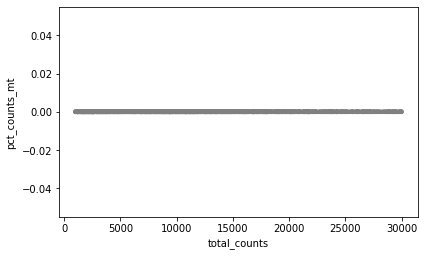

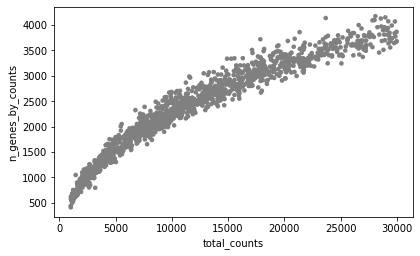

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:404: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:405: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:405: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9


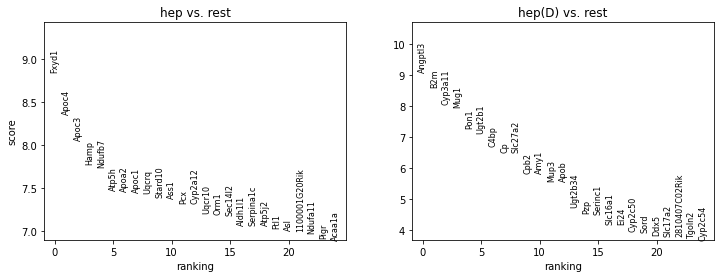

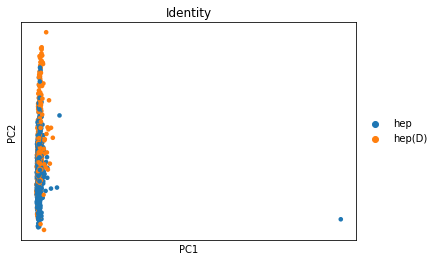

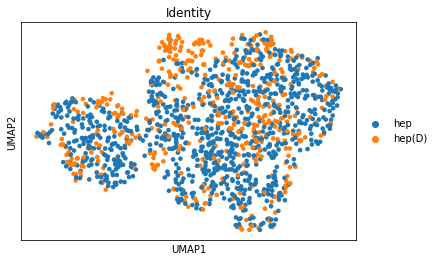

In [49]:
Init(adata_S1,
     output = 'hep',
     QC = True,
     RegressOutTotalCounts = True)

In [51]:
logFC = CalcFC(adata_S1, FC_base = 1, groupby = 'Identity', target_group = 'hep(D)')

UpGenes_hep, DnGenes_hep = SelectGenes(adata_S1,
                                       logFC,
                                       output = 'hep',
                                       target = 'hep(D)',
                                       pval_cutoff = 0.05,
                                       logFC_cutoff = 0.5)

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [52]:
print(UpGenes_hep.shape)
UpGenes_hep.head()

(25, 2)


,pvals_adj,logFC
Mug1,6.922439e-12,0.966142
Angptl3,2.813814e-15,0.922345
B2m,5.696973e-14,0.905697
Slc27a2,3.955619e-08,0.903927
Cyp3a11,3.592947e-12,0.891578


In [53]:
print(DnGenes_hep.shape)
DnGenes_hep.head()

(32, 2)


,pvals_adj,logFC
Apoc4,4.305449e-13,-0.953030
Apoc3,3.592947e-12,-0.867106
Apoc1,2.081958e-10,-0.770888
Ftl1,2.123184e-09,-0.753083
Fxyd1,1.279873e-14,-0.748965


C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


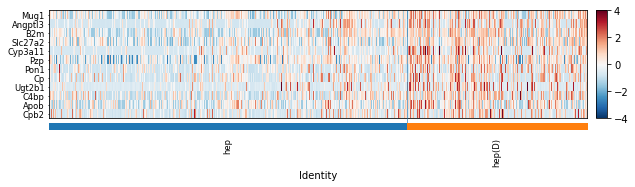

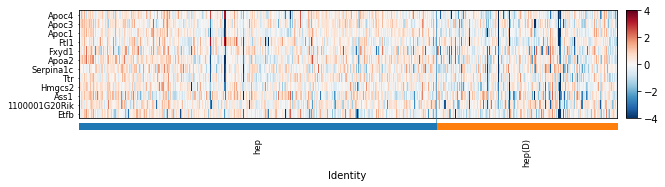

In [54]:
DEGHeatmap(adata_S1,
           UpGenes_hep,
           DnGenes_hep,
           groupby = 'Identity',
           output = 'hep',
           up_sta = 0,
           up_end = 12,
           down_sta = 0,
           down_end = 12,
           vmax = 4,
           vmin = -4)

# LEC

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Identity' as categorical


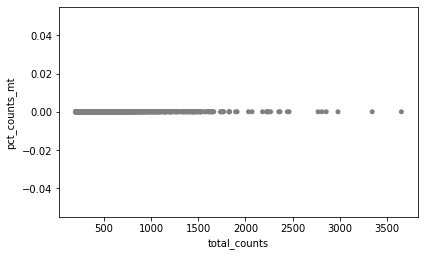

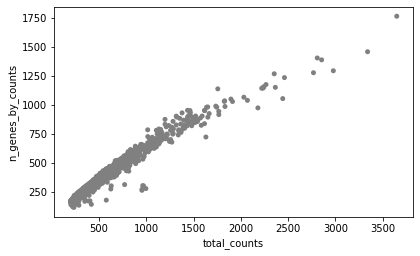

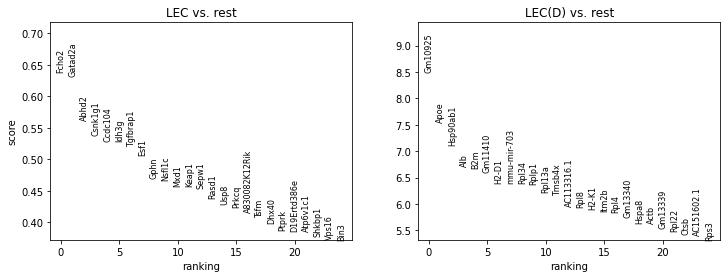

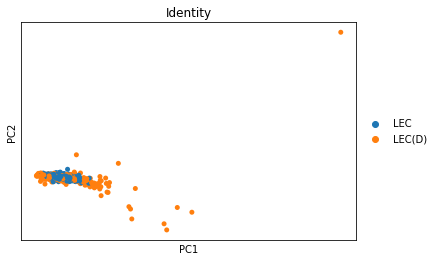

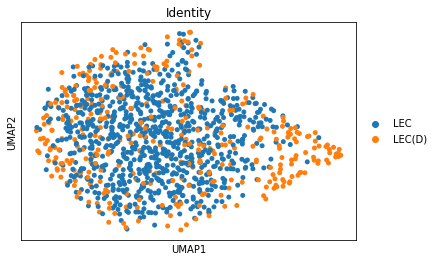

In [55]:
Init(adata_S2,
     output = 'LEC',
     QC = True,
     RegressOutTotalCounts = True)

In [56]:
logFC = CalcFC(adata_S2, FC_base = 1, groupby = 'Identity', target_group = 'LEC(D)')

UpGenes, DnGenes = SelectGenes(adata_S2,
                               logFC,
                               output = 'LEC',
                               target = 'LEC(D)',
                               pval_cutoff = 0.05,
                               logFC_cutoff = 0.5)

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [57]:
UpGenes

,pvals_adj,logFC


In [58]:
DnGenes

,pvals_adj,logFC


# All

In [38]:
adata_S1 = DF2adata(hep)
adata_S2 = DF2adata(LEC)

PFile1 = 'DecompResult/pred_0.01_hep_LEC_1.npy'
PFile2 = 'DecompResult/pred_0.01_hep_LEC_2.npy'

label_interaction(adata_S1, adata_S2, PFile1, PFile2,
                  doub_name1 = 'hep(D)',
                  nondoub_name1 = 'hep',
                  doub_name2 = 'LEC(D)',
                  nondoub_name2 = 'LEC')

adata_S12 = DF2adata(pcSeq)
adata_S12.obs['Identity'] = 'hep-LEC'

adata_all = ad.AnnData.concatenate(adata_S1, adata_S2, adata_S12)

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Identity' as categorical


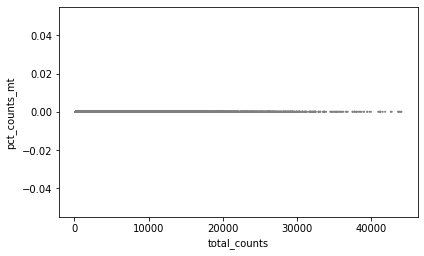

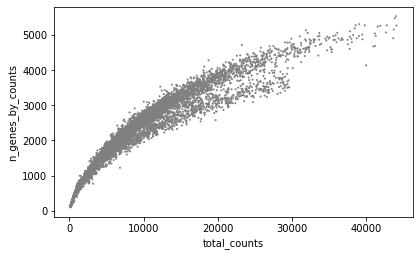

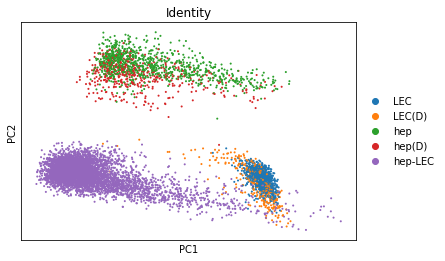

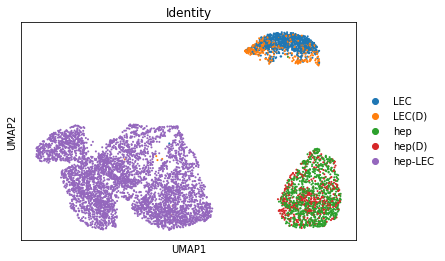

In [39]:
Init(adata_all,
     output = 'all',
     QC = True,
     RegressOutTotalCounts = True,
     DE = False)

C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
C:\Users\nrx398\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


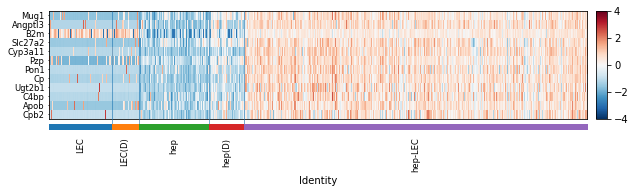

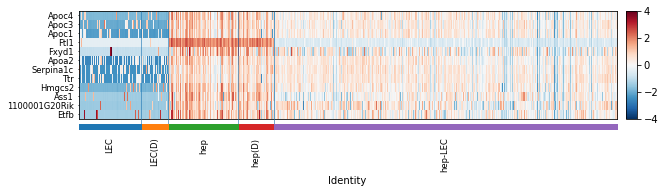

In [40]:
DEGHeatmap(adata_all,
           UpGenes_hep,
           DnGenes_hep,
           groupby = 'Identity',
           output = 'all_HepGenes',
           up_sta = 0,
           up_end = 12,
           down_sta = 0,
           down_end = 12,
           vmax = 4,
           vmin = -4)

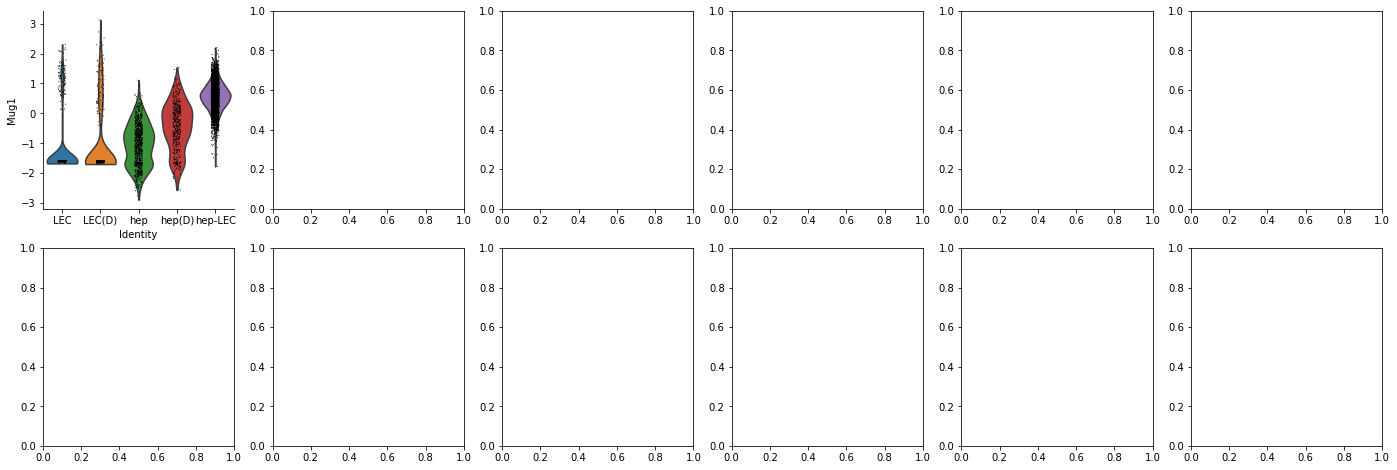

In [59]:
DEGViolin(adata_all,
          UpGenes_hep,
          groupby = 'Identity',
          output = 'all_HepGenes',
          num = 12,
          n_col = 6,
          n_row = 2,
          vmax = 4,
          vmin = -4)